## Data Preprocessing

In [1]:
! pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from PairsTradingKalmanFilter import *
from PairsTradingBacktest import *
from IPython.display import display, HTML
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Utils

In [110]:
def dict_to_df(dataset):
    """
    Transforms a dictionary of price series into a DataFrame.

    :param dataset: A dictionary containing tickers as keys and corresponding price series as values.
    :return: A DataFrame with tickers as columns.
    """

    first_count = True
    for k in dataset.keys():
        if dataset[k] is not None:
            if first_count:
                df = dataset[k]
                first_count = False
            else:
                df = pd.concat([df, dataset[k]], axis=1)

    return df


In [111]:
def split_data(df_prices, training_dates, testing_dates, remove_nan=True):
    """
    Splits a DataFrame of prices into training and testing sets.

    :param df_prices: DataFrame containing prices for all dates.
    :param training_dates: Tuple (training start date, training end date).
    :param testing_dates: Tuple (testing start date, testing end date).
    :param remove_nan: Whether to remove columns with any NaN values.

    :return: A tuple with DataFrames for training and testing prices.
    """

    if remove_nan:
        dataset_mask = (df_prices.index >= training_dates[0]) & (df_prices.index <= testing_dates[1])
        df_prices_dataset = df_prices[dataset_mask]
        print(f'Total of {df_prices_dataset.shape[1]} tickers')

        df_prices_dataset_without_nan = df_prices_dataset.dropna(axis=1)
        print(f'Total of {df_prices_dataset_without_nan.shape[1]} tickers after removing tickers with NaN values')

        df_prices = df_prices_dataset_without_nan.copy()

    train_mask = df_prices.index <= training_dates[1]
    test_mask = df_prices.index >= testing_dates[0]
    df_prices_train = df_prices[train_mask]
    df_prices_test = df_prices[test_mask]

    return df_prices_train, df_prices_test


In [112]:
# def outliers(df_real):
#     df = df_real.copy()

#     outliers = []
#     for ticker in df.columns:
#         outliers_idx = df[ticker][np.abs(df[ticker].pct_change()) > 0.5].index
#         if len(outliers_idx)>0:
#             outliers.append((ticker, outliers_idx))

#     return outliers

## Commodity-related ETF Dataset

In [6]:
! pip install tiingo

In [113]:
from tiingo import TiingoClient

config = {}

# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True

############################################
#### WARNING: This API key has a maximum request of 5000 per hour and 50000 per day!!!!!! Use it as wisely as you can
############################################
config['api_key'] = "07f7d2d67590540f45370e46555b2ea8c7eded8b"

# Initialize
client = TiingoClient(config)

In [135]:
ticker_list = ['USB', 'C']
df = yf.download(ticker_list, start = "2010-01-01", end = "2020-01-01")['Adj Close']
df

[*********************100%%**********************]  2 of 2 completed


Ticker,C,USB
Date,,
2010-01-04,26.409624,15.231899
2010-01-05,27.419399,15.618019
2010-01-06,28.273832,15.784451
2010-01-07,28.351501,16.090689
2010-01-08,27.885458,16.117321
...,...,...
2019-12-24,66.147713,49.412632
2019-12-26,67.191376,49.810120
2019-12-27,67.056709,49.462318


In [136]:
df.to_csv('MCO&MSCI.csv', index=True)
from google.colab import files
files.download('MCO&MSCI.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
tickers = ['USB', 'C']

In [138]:
len(tickers)

2

### Price

In [139]:
tickers = list(tickers)
frequency = 'daily'

error_counter = 0
dataset_tiingo = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = client.get_dataframe([ticker],
                                  frequency=frequency,
                                  metric_name='adjClose',
                                  startDate='2010-01-01',
                                  endDate='2020-01-01')
        series = df[ticker]
        series.name = ticker  # filter close price only
        dataset_tiingo[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for ' + ticker)

print('\nUnable to download ' + str(error_counter / len(tickers) * 100) + '% of the ETFs')

df_prices = dict_to_df(dataset_tiingo)
df_prices



Unable to download 0.0% of the ETFs


,USB,C
2010-01-04 00:00:00+00:00,15.252559,26.393525
2010-01-05 00:00:00+00:00,15.639206,27.402689
2010-01-06 00:00:00+00:00,15.805864,28.256598
2010-01-07 00:00:00+00:00,16.112515,28.334226
2010-01-08 00:00:00+00:00,16.139181,27.868457
...,...,...
2019-12-24 00:00:00+00:00,49.466219,66.095888
2019-12-26 00:00:00+00:00,49.864138,67.138755
2019-12-27 00:00:00+00:00,49.515959,67.004192
2019-12-30 00:00:00+00:00,49.399900,66.869628


In [140]:
# sort by the timestamp
df_prices = df_prices.sort_index()
df_prices

,USB,C
2010-01-04 00:00:00+00:00,15.252559,26.393525
2010-01-05 00:00:00+00:00,15.639206,27.402689
2010-01-06 00:00:00+00:00,15.805864,28.256598
2010-01-07 00:00:00+00:00,16.112515,28.334226
2010-01-08 00:00:00+00:00,16.139181,27.868457
...,...,...
2019-12-24 00:00:00+00:00,49.466219,66.095888
2019-12-26 00:00:00+00:00,49.864138,67.138755
2019-12-27 00:00:00+00:00,49.515959,67.004192
2019-12-30 00:00:00+00:00,49.399900,66.869628


In [141]:
# We try to fill sporadic null values. For this purpose we can use either the `interpolate` or the
# `fillna` function.
# src: https://datascience.stackexchange.com/questions/25924/difference-between-interpolate-and-fillna-in-pandas.
# Using the limit parameter, we can set the maximum number of consecutive NaNs to fill.

limit = 10
df_prices_interpolate = df_prices.interpolate(method="linear",limit=limit)
df_prices_interpolate

,USB,C
2010-01-04 00:00:00+00:00,15.252559,26.393525
2010-01-05 00:00:00+00:00,15.639206,27.402689
2010-01-06 00:00:00+00:00,15.805864,28.256598
2010-01-07 00:00:00+00:00,16.112515,28.334226
2010-01-08 00:00:00+00:00,16.139181,27.868457
...,...,...
2019-12-24 00:00:00+00:00,49.466219,66.095888
2019-12-26 00:00:00+00:00,49.864138,67.138755
2019-12-27 00:00:00+00:00,49.515959,67.004192
2019-12-30 00:00:00+00:00,49.399900,66.869628


### Volume

In [142]:
# get info about volume
frequency = 'daily'
error_counter = 0
dataset_tiingo_volume = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = client.get_dataframe([ticker],
                                  frequency=frequency,
                                  metric_name='volume',
                                  startDate='2010-01-01',
                                  endDate='2020-01-01')
        series = df[ticker]
        series.name = ticker  # filter close price only
        dataset_tiingo_volume[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for ' + ticker)

print('\nUnable to download info about volume from ' + str(error_counter / len(tickers) * 100) + '% of the ETFs')

df_volume = dict_to_df(dataset_tiingo_volume)
df_volume


Unable to download info about volume from 0.0% of the ETFs


,USB,C
2010-01-04 00:00:00+00:00,12891700,406793000
2010-01-05 00:00:00+00:00,14503500,668617000
2010-01-06 00:00:00+00:00,12293600,674338000
2010-01-07 00:00:00+00:00,15241200,672451000
2010-01-08 00:00:00+00:00,9935000,624097000
...,...,...
2019-12-24 00:00:00+00:00,2246178,4576212
2019-12-26 00:00:00+00:00,4155052,11991175
2019-12-27 00:00:00+00:00,3661560,10867891
2019-12-30 00:00:00+00:00,4020131,10084912


In [143]:
df_volume = df_volume.sort_index()
df_volume

,USB,C
2010-01-04 00:00:00+00:00,12891700,406793000
2010-01-05 00:00:00+00:00,14503500,668617000
2010-01-06 00:00:00+00:00,12293600,674338000
2010-01-07 00:00:00+00:00,15241200,672451000
2010-01-08 00:00:00+00:00,9935000,624097000
...,...,...
2019-12-24 00:00:00+00:00,2246178,4576212
2019-12-26 00:00:00+00:00,4155052,11991175
2019-12-27 00:00:00+00:00,3661560,10867891
2019-12-30 00:00:00+00:00,4020131,10084912


In [144]:
# interpolate
limit = 10
df_volume = df_volume.interpolate(method="linear",limit=limit)
df_volume

,USB,C
2010-01-04 00:00:00+00:00,12891700,406793000
2010-01-05 00:00:00+00:00,14503500,668617000
2010-01-06 00:00:00+00:00,12293600,674338000
2010-01-07 00:00:00+00:00,15241200,672451000
2010-01-08 00:00:00+00:00,9935000,624097000
...,...,...
2019-12-24 00:00:00+00:00,2246178,4576212
2019-12-26 00:00:00+00:00,4155052,11991175
2019-12-27 00:00:00+00:00,3661560,10867891
2019-12-30 00:00:00+00:00,4020131,10084912


## Data Cleaning

In [145]:
initial_train_date = pd.to_datetime('2010-01-01', utc=True)
final_train_date = pd.to_datetime('2018-01-01', utc=True)
initial_test_date = pd.to_datetime('2018-01-01', utc=True)
final_test_date = pd.to_datetime('2019-12-31', utc=True)

### Discard ETFs that were not traded during at least one day

In [146]:
# split data in training and test
df_volume_train, df_volume_test = split_data(df_volume,
                                             (initial_train_date,final_train_date),
                                             (initial_test_date,final_test_date),
                                             remove_nan=True)

# interpolate for single day ocurrences
df_volume_train = df_volume_train.replace(to_replace=0,value=np.nan)
df_volume_train = df_volume_train.interpolate(method="linear",limit=2)
# replace again by zeros
df_volume_train = df_volume_train.replace(to_replace=np.nan,value=0)

# Calculate the number of days with zero trading volume for each ETF.
zero_counts = (df_volume_train == 0).sum(axis=0)
# Select the ETFs with at least one day of zero trading volume.
etfs_with_zero_volume = zero_counts[zero_counts > 0]
# Output the number of ETFs that need to be removed due to insufficient liquidity.
print('Must remove {} tickers because of insufficient liquidity'.format(len(etfs_with_zero_volume)))
# Obtain the list of ETFs that need to be removed.
tickers_to_remove = list(etfs_with_zero_volume.index)
tickers_to_remove

Total of 2 tickers
Total of 2 tickers after removing tickers with NaN values
Must remove 0 tickers because of insufficient liquidity


[]

In [147]:
df_prices_interpolate = df_prices_interpolate.drop(columns=tickers_to_remove)
df_prices_interpolate

,USB,C
2010-01-04 00:00:00+00:00,15.252559,26.393525
2010-01-05 00:00:00+00:00,15.639206,27.402689
2010-01-06 00:00:00+00:00,15.805864,28.256598
2010-01-07 00:00:00+00:00,16.112515,28.334226
2010-01-08 00:00:00+00:00,16.139181,27.868457
...,...,...
2019-12-24 00:00:00+00:00,49.466219,66.095888
2019-12-26 00:00:00+00:00,49.864138,67.138755
2019-12-27 00:00:00+00:00,49.515959,67.004192
2019-12-30 00:00:00+00:00,49.399900,66.869628


In [148]:
# split data in training and test
df_prices_train, df_prices_test = split_data(df_prices_interpolate,
                                                            (initial_train_date,
                                                             final_train_date),
                                                            (initial_test_date,
                                                             final_test_date),
                                                            remove_nan=True)
print('Total days of trading: ', len(df_prices_train)+len(df_prices_test))

Total of 2 tickers
Total of 2 tickers after removing tickers with NaN values
Total days of trading:  2516


In [149]:
df_prices_train

,USB,C
2010-01-04 00:00:00+00:00,15.252559,26.393525
2010-01-05 00:00:00+00:00,15.639206,27.402689
2010-01-06 00:00:00+00:00,15.805864,28.256598
2010-01-07 00:00:00+00:00,16.112515,28.334226
2010-01-08 00:00:00+00:00,16.139181,27.868457
...,...,...
2017-12-22 00:00:00+00:00,42.732069,60.414460
2017-12-26 00:00:00+00:00,42.378977,59.846249
2017-12-27 00:00:00+00:00,42.426056,59.934281
2017-12-28 00:00:00+00:00,42.567293,60.086338


In [150]:
df_prices_test

,USB,C
2018-01-02 00:00:00+00:00,42.630414,59.510124
2018-01-03 00:00:00+00:00,43.048591,59.694192
2018-01-04 00:00:00+00:00,43.379977,60.430466
2018-01-05 00:00:00+00:00,43.648242,60.350436
2018-01-08 00:00:00+00:00,43.711363,59.646174
...,...,...
2019-12-24 00:00:00+00:00,49.466219,66.095888
2019-12-26 00:00:00+00:00,49.864138,67.138755
2019-12-27 00:00:00+00:00,49.515959,67.004192
2019-12-30 00:00:00+00:00,49.399900,66.869628


In [151]:
df_prices_train.isna().any().any()

False

In [152]:
df_prices_test.isna().any().any()

False

In [106]:
! pip install --upgrade jinja2
! pip install tiingo
! pip install pykalman

In [153]:
ticker_list = ['USB', 'C']
prices = yf.download(ticker_list, start = "2018-01-01", end = "2020-01-01")['Adj Close']
prices

[*********************100%%**********************]  2 of 2 completed


Ticker,C,USB
Date,,
2018-01-02,59.538174,42.577728
2018-01-03,59.722317,42.995388
2018-01-04,60.458942,43.326366
2018-01-05,60.378868,43.594303
2018-01-08,59.674271,43.657333
...,...,...
2019-12-24,66.147690,49.412640
2019-12-26,67.191383,49.810123
2019-12-27,67.056732,49.462318


In [154]:
index = prices.index

In [155]:
# S&P500 ETF
# sp500 = yf.download('SPY', start=index[0], end=index[-1])['Adj Close']
sp500 = yf.download('^GSPC', start=index[0], end=index[-1])['Adj Close']
sp500_nav = sp500 / sp500.iloc[0]
sp500_drawdowns = calculate_drawdown(sp500_nav)

# US Treasury
USTreasury = yf.download('^TNX', start=index[0], end=index[-1])['Adj Close']
USTreasury_daily_returns = (USTreasury / 100) / 252
USTreasury_nav = pd.Series(index=USTreasury.index)
USTreasury_nav.iloc[0] = 1
for i in range(1, len(USTreasury_daily_returns)):
    USTreasury_nav.iloc[i] = USTreasury_nav.iloc[i - 1] * (1 + USTreasury_daily_returns.iloc[i])
USTreasury_drawdowns = calculate_drawdown(USTreasury_nav)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


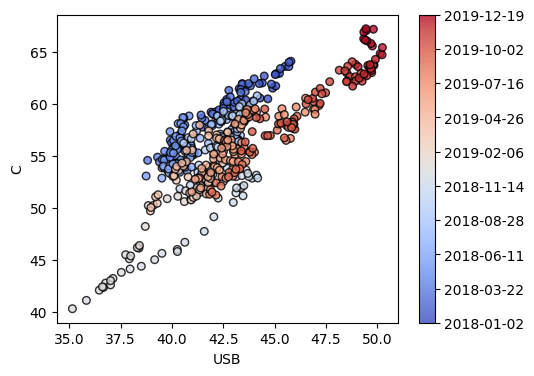

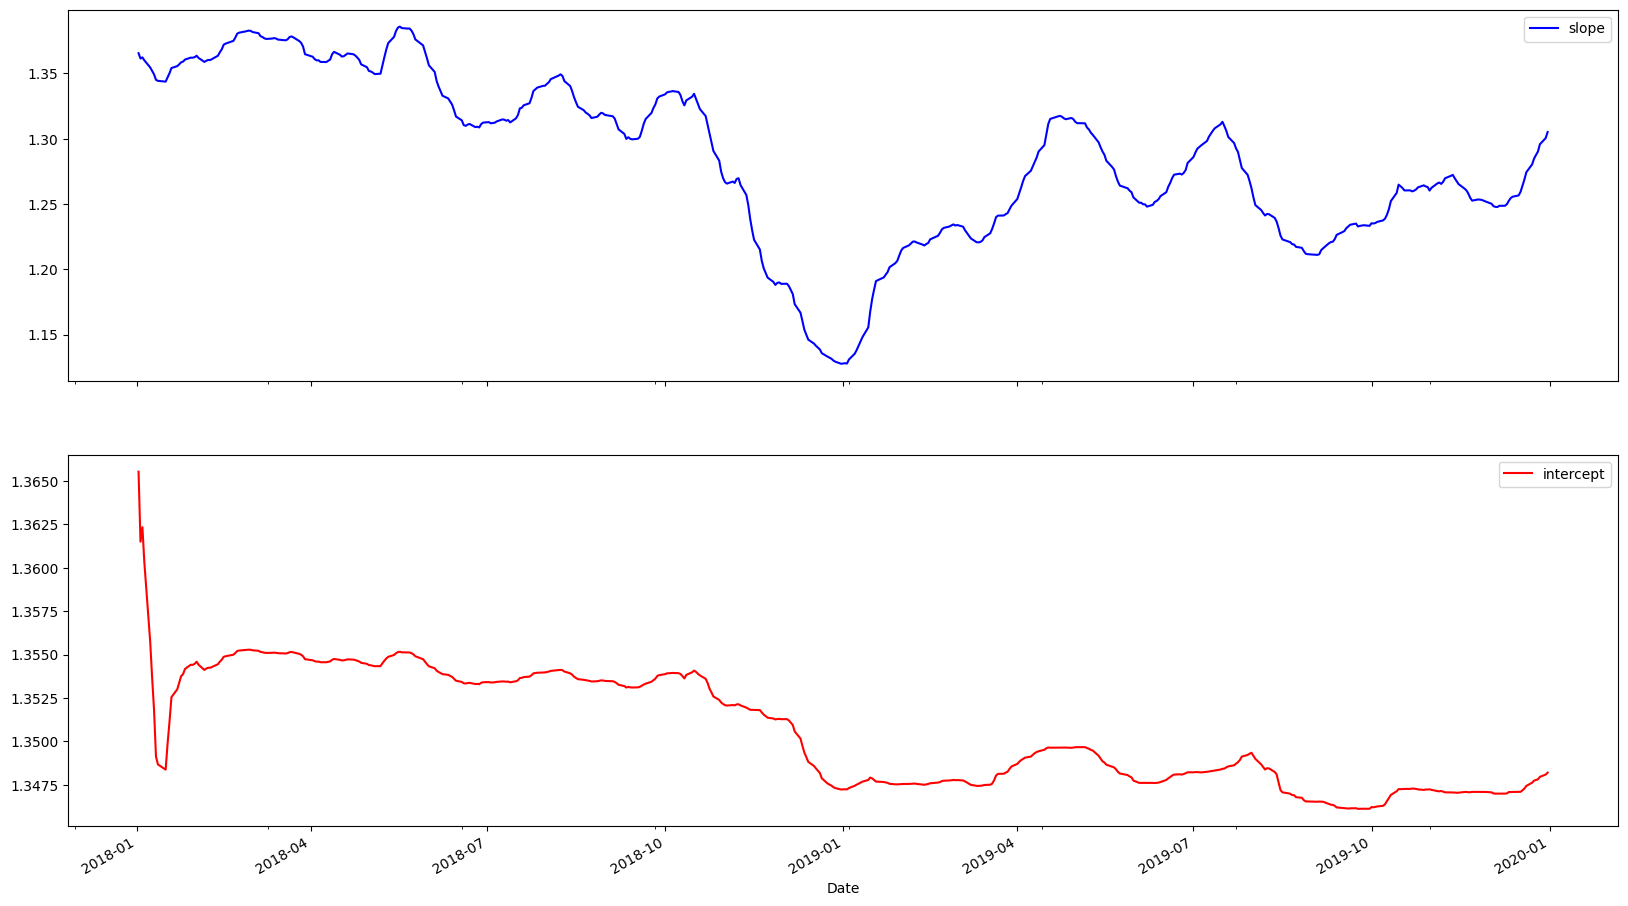

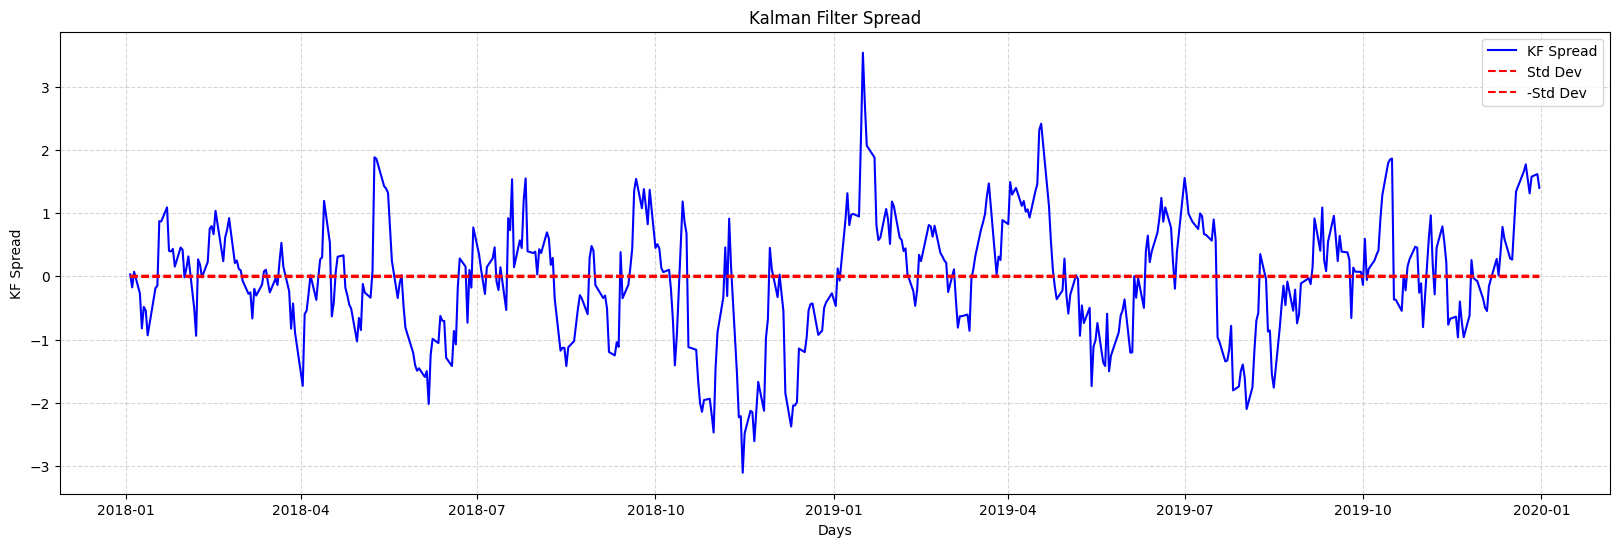

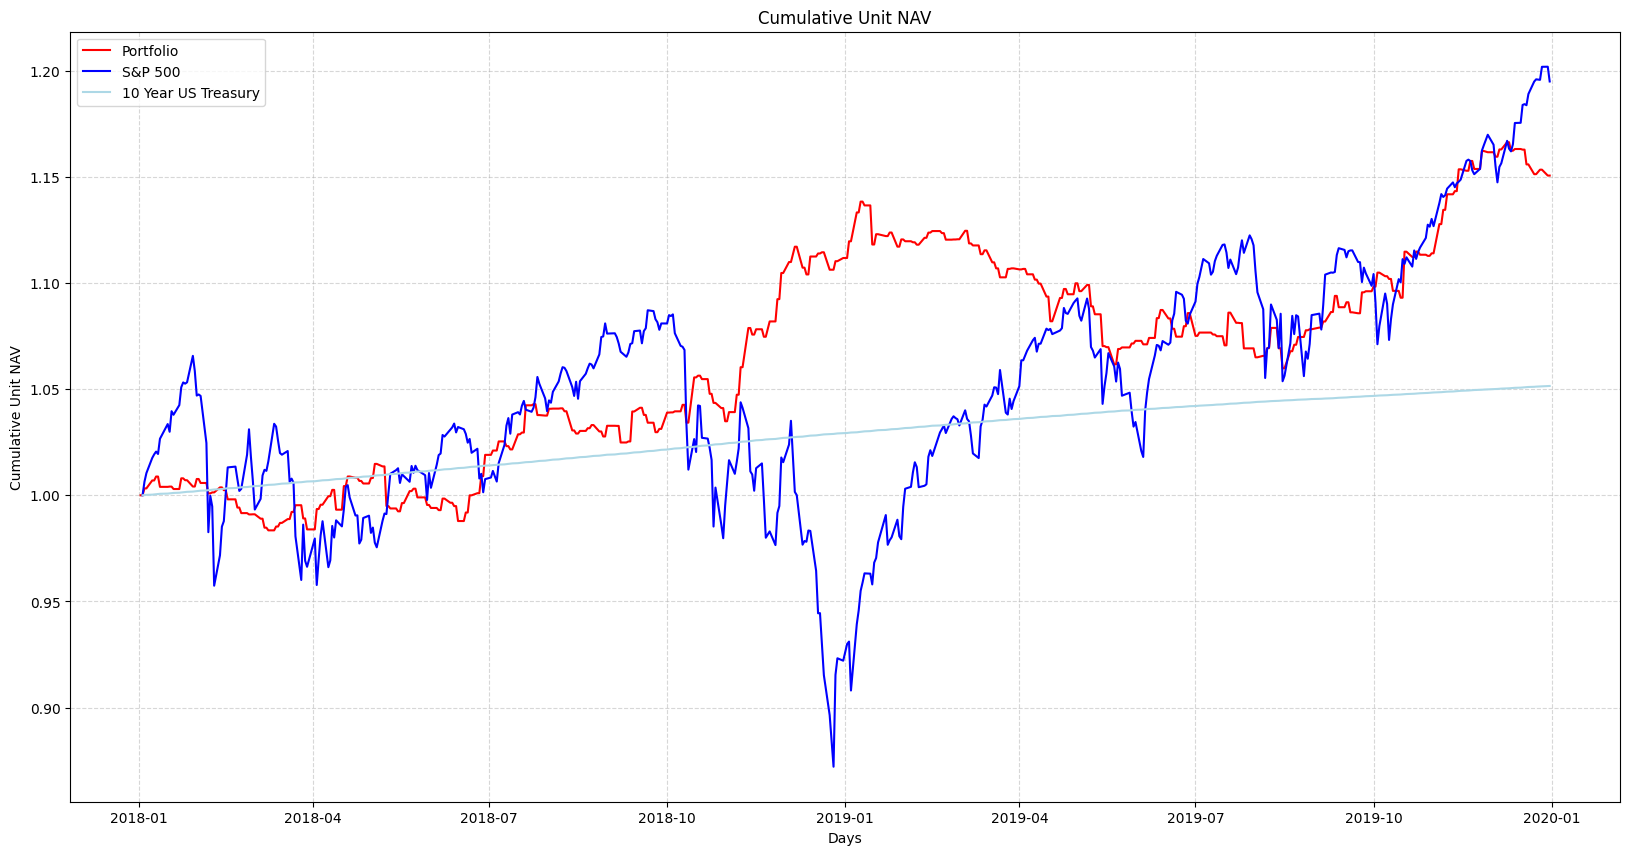

AttributeError: 'Styler' object has no attribute 'render'

In [156]:
etfs_list = [ ('USB', 'C')]
# etfs_list = [ ('AMJ', 'CORN'), ('AMU', 'WEAT'), ('RING', 'GLD'), ('SGDM', 'CORN'), ('AMJ', 'OUNZ'), ('CORN', 'SGOL')]
pnl_dict = {}
nav_dict = {}
drawdowns_dict = {}
k = 0.01


for etfs in etfs_list:
    print("\n")
    display(HTML(f'<p style="font-size: 30px;">{etfs}</p>'))
    print("\n")
    draw_date_coloured_scatterplot(etfs, prices)
    state_means, state_covs = calc_slope_intercept_kalman(etfs, prices)
    draw_slope_intercept_changes(prices, state_means)

    # Run the backtest
    context = Context()
    initialize(context, etfs, prices)
#     context.state_means, context.state_covs = calc_slope_intercept_kalman(etfs, prices)
#     context.tickers = etfs

    ### DEBUG
    context.etf1_price_prev = df_prices_test[etfs[0]].iloc[0]
    context.etf2_price_prev = df_prices_test[etfs[1]].iloc[0]

#     print("etf1_price_prev: ", context.etf1_price_prev)
#     print("etf2_price_prev: ", context.etf2_price_prev)

    for i in range(len(df_prices_test) - 1):
        handle_data(context, prices.iloc[: i+1], etfs, k)

    # forecast error
    errors = context.errors

    # forecast standard deviation
    stds = context.stds
    neg_stds = [-x for x in stds]

    # pnl
    pnl = context.pnl_history
    pnl_dict[etfs] = pnl

    # NAV
    nav = context.nav_history
    nav_dict[etfs] = nav

    # daily returns
    daily_returns = context.daily_returns

    # cumulative returns
    cum_returns = np.cumprod(1 + np.array(context.daily_returns)) - 1

    #drawdown
    ### DEBUG
    highwatermarks = np.maximum.accumulate(nav)
    drawdowns = (nav - highwatermarks) / highwatermarks
    drawdowns_dict[etfs] = drawdowns

    # plot figures
    plot_spread(prices, errors, stds, neg_stds)
    plot_nav_sp500(prices, nav, sp500_nav, USTreasury_nav)
#     plot_cum_returns(prices, cum_returns)
#     plot_drawdown(prices, drawdowns)
    display(HTML(pnl_metrics(daily_returns, sp500_nav, sp500_drawdowns, USTreasury_nav, USTreasury_drawdowns).style.set_table_attributes('style="font-size: 16px;"').render()))
    print('\n\n\n')


In [106]:
sp500_nav

Date
2019-01-02    1.000000
2019-01-03    0.975243
2019-01-04    1.008729
2019-01-07    1.015801
2019-01-08    1.025649
                ...   
2023-12-21    1.891113
2023-12-22    1.894252
2023-12-26    1.902268
2023-12-27    1.904989
2023-12-28    1.905694
Name: Adj Close, Length: 1257, dtype: float64

In [107]:
len(nav)

1258